**LOAD DATA**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_excel('datasetiris.xlsx')

print(data.head())
print(data.tail())
print(data.info())

   COL1  COL2  COL3  COL4       TARGET
0   5.1   3.5   1.4   0.2  Iris-setosa
1   4.9   3.0   1.4   0.2  Iris-setosa
2   4.7   3.2   1.3   0.2  Iris-setosa
3   4.6   3.1   1.5   0.2  Iris-setosa
4   5.0   3.6   1.4   0.2  Iris-setosa
    COL1  COL2  COL3  COL4           TARGET
95   5.7   3.0   4.2   0.2  Iris-versicolor
96   5.7   2.9   4.2   0.2  Iris-versicolor
97   6.2   2.9   4.3   0.2  Iris-versicolor
98   5.1   2.5   3.0   0.2  Iris-versicolor
99   5.7   2.8   4.1   0.2  Iris-versicolor
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COL1    100 non-null    float64
 1   COL2    100 non-null    float64
 2   COL3    100 non-null    float64
 3   COL4    100 non-null    float64
 4   TARGET  100 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.0+ KB
None


**PREPROCESSING**

In [28]:
# Iris-setosa -> 0, Iris-versicolor -> 1
data['TARGET'] = data['TARGET'].map({'Iris-setosa': 0, 'Iris-versicolor': 1})

# Ekstrak fitur (COL1, COL2, COL3, COL4) dan target
X = data[['COL1', 'COL2', 'COL3', 'COL4']]
y = data['TARGET']

# Validasi Datanya dari baris 11-20 (setosa) dan 71-80 (versicolor)
val_indices = list(range(10, 20)) + list(range(70, 80))
train_indices = [i for i in range(len(X)) if i not in val_indices]

# Split Data
X_train = X.iloc[train_indices]
y_train = y.iloc[train_indices]
X_val = X.iloc[val_indices]
y_val = y.iloc[val_indices]

# Convert ke numpy array
X_train = np.array(X_train).astype(float)
y_train = np.array(y_train).astype(int)
X_val = np.array(X_val).astype(float)
y_val = np.array(y_val).astype(int)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (80, 4)
Validation data shape: (20, 4)


**DEFINE SLP**

In [ ]:
class SLP:
    def __init__(self, n_features, learning_rate=0.1):
        self.learning_rate = learning_rate
        # Inisialisasi bobot dan bias adalah 0.5
        self.weights = np.full(n_features, 0.5)
        self.bias = 0.5
        
        # Untuk tracking training history
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
    
    def dot_product(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def mse_loss(self, y_true, y_pred):
        return (y_pred - y_true) ** 2
    
    def update_weights_bias_online(self, x, y_true, y_pred):
        error = y_pred - y_true
        sigmoid_derivative = y_pred * (1 - y_pred)
        gradient = 2 * error * sigmoid_derivative
        
        # Update weights 
        dw = gradient * x
        self.weights -= self.learning_rate * dw
        
        # Update bias 
        db = gradient
        self.bias -= self.learning_rate * db
    
    def predict_proba(self, X):
        z = self.dot_product(X)
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=5):
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            
            total_train_loss = 0
            correct_train_predictions = 0
            
            # Gradient Descent 
            for x_sample, y_sample in zip(X_train, y_train):
                # Forward pass 
                y_pred_sample = self.predict_proba(x_sample.reshape(1, -1))[0]
                
                # Hitung loss per sample
                total_train_loss += self.mse_loss(y_sample, y_pred_sample)
                
                # Update weights dan bias 
                self.update_weights_bias_online(x_sample, y_sample, y_pred_sample)
                
                # Hitung akurasi
                class_pred = 1 if y_pred_sample >= 0.5 else 0
                if class_pred == y_sample:
                    correct_train_predictions += 1
            
            # Rata-rata loss dan akurasi untuk training
            train_loss = total_train_loss / len(X_train)
            train_acc = correct_train_predictions / len(X_train)
            
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            
            # Validation jika disediakan
            if X_val is not None and y_val is not None:
                total_val_loss = 0
                correct_val_predictions = 0
                for x_val_sample, y_val_sample in zip(X_val, y_val):
                    y_pred_val = self.predict_proba(x_val_sample.reshape(1, -1))[0]
                    total_val_loss += self.mse_loss(y_val_sample, y_pred_val)
                    class_pred = 1 if y_pred_val >= 0.5 else 0
                    if class_pred == y_val_sample:
                        correct_val_predictions += 1
                
                val_loss = total_val_loss / len(X_val)
                val_acc = correct_val_predictions / len(X_val)
                
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
                
                print(f"  Train Loss: {train_loss:.8f}, Train Acc: {train_acc:.8f}, Val Loss: {val_loss:.8f}, Val Acc: {val_acc:.8f}")
            else:
                print(f"  Train Loss: {train_loss:.8f}, Train Acc: {train_acc:.8f}")
            
            print(f"  Weights: {self.weights}")
            print(f"  Bias: {self.bias}")
            print()

**TRAINING MODEL**

In [30]:
# Inisialisasi SLP
slp = SLP(n_features=4, learning_rate=0.1)

# Latih model untuk 5 epoch
slp.fit(X_train, y_train, X_val, y_val, epochs=5)

# Cetak bobot dan bias akhir
print("Final Weights:", slp.weights)
print("Final Bias:", slp.bias)

Epoch 1/5
  Train Loss: 0.43868669, Train Acc: 0.53750000, Val Loss: 0.37960430, Val Acc: 0.50000000
  Weights: [0.05531201 0.09653392 0.55751062 0.47722088]
  Bias: 0.38610439096830806

Epoch 2/5
  Train Loss: 0.05445645, Train Acc: 0.92500000, Val Loss: 0.29794386, Val Acc: 0.50000000
  Weights: [-0.01432073 -0.06628048  0.77229122  0.46895168]
  Bias: 0.3447584133432854

Epoch 3/5
  Train Loss: 0.03512575, Train Acc: 0.95000000, Val Loss: 0.21628733, Val Acc: 0.50000000
  Weights: [-0.07316451 -0.20149964  0.96028306  0.46205194]
  Bias: 0.31025968376301005

Epoch 4/5
  Train Loss: 0.02439017, Train Acc: 0.97500000, Val Loss: 0.14682197, Val Acc: 0.65000000
  Weights: [-0.1226659  -0.32228832  1.12631385  0.45594455]
  Bias: 0.27972276606068

Epoch 5/5
  Train Loss: 0.01812808, Train Acc: 0.97500000, Val Loss: 0.09464519, Val Acc: 0.90000000
  Weights: [-0.16565876 -0.43258496  1.27259813  0.45046743]
  Bias: 0.25233713950425984

Final Weights: [-0.16565876 -0.43258496  1.27259813  

In [ ]:
results_df = pd.DataFrame({
    'Epoch': range(1, 6),
    'Train Loss': slp.train_losses,
    'Train Accuracy': slp.train_accuracies,
    'Validation Loss': slp.val_losses,
    'Validation Accuracy': slp.val_accuracies
})

print(results_df.to_string(float_format='{:.8f}'.format))

   Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
0      1  0.43868669      0.53750000       0.37960430           0.50000000
1      2  0.05445645      0.92500000       0.29794386           0.50000000
2      3  0.03512575      0.95000000       0.21628733           0.50000000
3      4  0.02439017      0.97500000       0.14682197           0.65000000
4      5  0.01812808      0.97500000       0.09464519           0.90000000


**VISUALISASI**

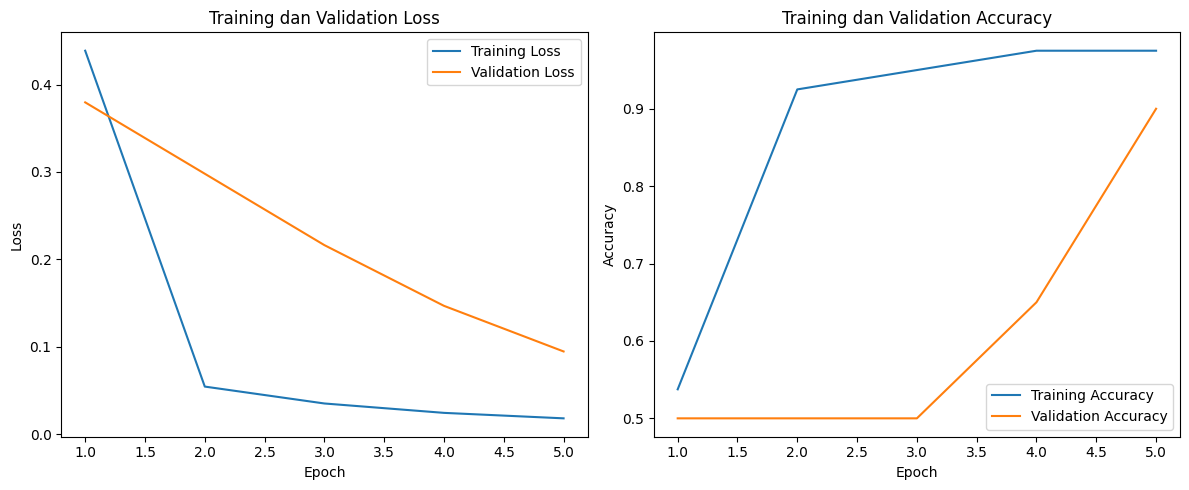

In [32]:
# Plot Training dan Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 6), slp.train_losses, label='Training Loss')
plt.plot(range(1, 6), slp.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training dan Validation Loss')
plt.legend()

# Plot Training dan Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), slp.train_accuracies, label='Training Accuracy')
plt.plot(range(1, 6), slp.val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training dan Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()